# How To Backtest Machine Learning Models for Time Series Forecasting
Brownlee, Jason. August 28, 2019. [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/#comment-530151)

## Monthly Sunspot Dataset

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited as Andrews & Herzberg (1985).

[Download the dataset.](https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv)

## Load Sunspot Dataset

Sunspots
Month            
1749-01      58.0
1749-02      62.6
1749-03      70.0
1749-04      55.7
1749-05      85.0


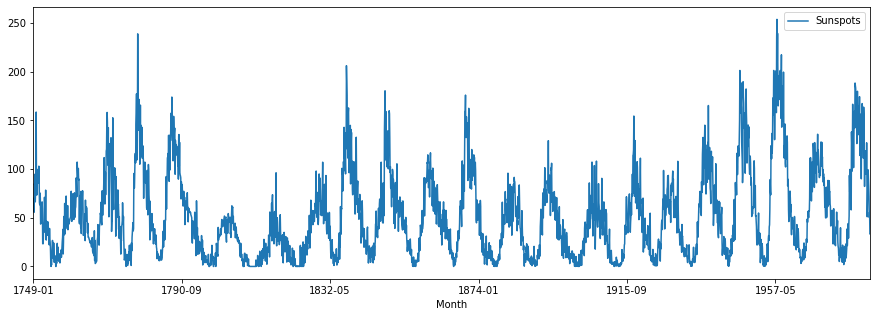

In [64]:
# Load sunspot data
from pandas import read_csv
from matplotlib import pyplot
from pylab import rcParams

%matplotlib inline

series = read_csv('.\\data\\monthly.sunspot.data.csv', header=0, index_col=0)
print(series.head())

rcParams['figure.figsize'] = 15, 5
series.plot()
pyplot.show()

## Train-Test Split

You can split your dataset into training and testing subsets.

Your model can be prepared on the training dataset and predictions can be made and evaluated for the test dataset.

This can be done by selecting an arbitrary split point in the ordered list observations and creating two new datasets. Depending on the amount of data you have available and the amount of data required, you can use splits of 50-50, 70-30 and 90-10.

After loading the dataset as a Pandas Series, we can extract the NumPy array of data values. The split point can be calculated as a specific index in the array. All records up to the split point are taken as the training dataset and all records from the split point to the end of the list of observations are taken as the test set.

Below is an example of this in Python using a split of 66-34.

In [65]:
from pandas import read_csv

series = read_csv('.\\data\\monthly.sunspot.data.csv', header=0, index_col=0)

X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 2820
Training Observations: 1861
Testing Observations: 959


Observations: 2820
Training Observations: 1861
Testing Observations: 959


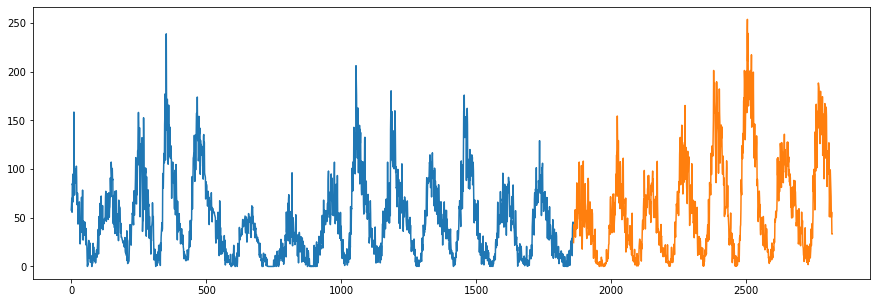

In [66]:
from pandas import read_csv
from matplotlib import pyplot
from pylab import rcParams

%matplotlib inline

series = read_csv('.\\data\\monthly.sunspot.data.csv', header=0, index_col=0)

X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

rcParams['figure.figsize'] = 15, 5
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

## Multiple Train-Test Splits

We can repeat the process of splitting the time series into train and test sets multiple times.

This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.

We could do this manually by repeating the process described in the previous section with different split points.

Alternately, the scikit-learn library provides this capability for us in the TimeSeriesSplit object.

You must specify the number of splits to create and the TimeSeriesSplit to return the indexes of the train and test observations for each requested split.

The total number of training and test observations are calculated each split iteration (i) as follows:

training_size = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
test_size = n_samples / (n_splits + 1)

In [67]:
# visual sample
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


Training Observations: 705
Testing Observations: 705
Observations: 1410
***
Training Observations: 1410
Testing Observations: 705
Observations: 2115
***
Training Observations: 2115
Testing Observations: 705
Observations: 2820
***


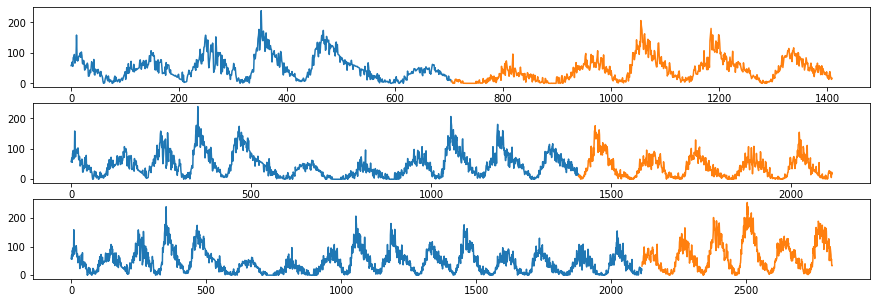

In [68]:
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

series = read_csv('.\\data\\monthly.sunspot.data.csv', header=0, index_col=0)

X = series.values
splits = TimeSeriesSplit(n_splits=3)

pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]	
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    print('Observations: %d' % (len(train) + len(test)))
    print('***')
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data.

A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set.

This may not be realistic as models can be retrained as new daily or monthly observations are made available. This concern is addressed in the next section.

## Walk Forward Validation

In practice, we very likely will retrain our model as new data becomes available.

This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption.

There are few decisions to make:

1. **Minimum Number of Observations**. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).

2. **Sliding or Expanding Window**. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

After a sensible configuration is chosen for your test-setup, models can be trained and evaluated.

1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

Because this methodology **involves moving along the time series one-time step at a time**, it is often `called Walk Forward Testing` or `Walk Forward Validation`. Additionally, because a **sliding or expanding window is used to train a model**, this method is also referred to as `Rolling Window Analysis` or a `Rolling Forecast`.

In [69]:
from pandas import read_csv
from matplotlib import pyplot

series = read_csv('.\\data\\monthly.sunspot.data.csv', header=0, index_col=0)

X = series.values
n_train = 500
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

767, test=1
train=1768, test=1
train=1769, test=1
train=1770, test=1
train=1771, test=1
train=1772, test=1
train=1773, test=1
train=1774, test=1
train=1775, test=1
train=1776, test=1
train=1777, test=1
train=1778, test=1
train=1779, test=1
train=1780, test=1
train=1781, test=1
train=1782, test=1
train=1783, test=1
train=1784, test=1
train=1785, test=1
train=1786, test=1
train=1787, test=1
train=1788, test=1
train=1789, test=1
train=1790, test=1
train=1791, test=1
train=1792, test=1
train=1793, test=1
train=1794, test=1
train=1795, test=1
train=1796, test=1
train=1797, test=1
train=1798, test=1
train=1799, test=1
train=1800, test=1
train=1801, test=1
train=1802, test=1
train=1803, test=1
train=1804, test=1
train=1805, test=1
train=1806, test=1
train=1807, test=1
train=1808, test=1
train=1809, test=1
train=1810, test=1
train=1811, test=1
train=1812, test=1
train=1813, test=1
train=1814, test=1
train=1815, test=1
train=1816, test=1
train=1817, test=1
train=1818, test=1
train=1819, test=1


You can see that many more models are created.

This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. This improved estimate comes at the computational cost of creating so many models.

This is not expensive if the modeling method is simple or dataset is small (as in this example), but could be an issue at scale. In the above case, 2,320 (or 2,820 – 500) models would be created and evaluated.

As such, careful attention needs to be paid to the window width and window type. These could be adjusted to contrive a test harness on your problem that is significantly less computationally expensive.

Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross validation of the time series world and is recommended for your own projects.

## Further Reading
- [sklearn.model_selection](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).TimeSeriesSplit API Documentation
- [Rolling-Window Analysis of Time-Series Models](https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html) for more on rolling windows.
- [Backtesting on Wikipedia](https://en.wikipedia.org/wiki/Backtesting) to learn more about backtesting.